In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import argparse
import os
import sys
import time
import math
from glob import glob
import SimpleITK as sitk
from scipy import ndimage
from scipy import misc
import cv2
from tqdm import tqdm
from natsort import natsorted
import h5py
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

In [2]:
npz_files = glob('project_TransUNet/project_TransUNet/data/Synapse/train_npz/*.npz')


In [3]:
def visualize_data_at_index(npz_files, index):
    npz_file_path = npz_files[index]
    npz_file = np.load(npz_file_path)
    image, image_label = npz_file['image'], npz_file['label']
    # show image
    plt.imshow(image)
    plt.show()

    # show label
    plt.imshow(image_label)
    plt.show()
    
def get_npz_image_at_index(npz_files, index):
    npz_file_path = npz_files[index]
    npz_file = np.load(npz_file_path)
    image, image_label = npz_file['image'], npz_file['label']
    return image, image_label

In [4]:
# read project_TransUNet\project_TransUNet\data\seg\TumorSegmentation_data\Segmentation_data\Training\Brains\mri_0.mhd and mri_0.raw
def read_mhd_and_raw(mhd_file_path):
    # returns the image array, origin and spacing of a .mhd image file
    # image aray is a numpy array containing the respective image
    # origin is a numpy array containing the x,y,z coordinates of the origin of the image
    # spacing is a numpy array containing the pixel spacing


    itkimage = sitk.ReadImage(mhd_file_path)
    image_array = sitk.GetArrayFromImage(itkimage)
    origin = np.array(itkimage.GetOrigin())
    spacing = np.array(itkimage.GetSpacing())
    return image_array, origin, spacing



In [18]:
image_mhd_files = glob('project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/Segmentation_data/Training/Brains/*.mhd')
label_mhd_files = glob('project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/Segmentation_data/Training/Labels/*.mhd')
image_mhd_files = natsorted(image_mhd_files)
label_mhd_files = natsorted(label_mhd_files)


In [19]:
def visualize_data_at_index_mhd(mhd_files, index):
    mhd_file_path = mhd_files[index]
    print(mhd_file_path)
    image_array, origin, spacing = read_mhd_and_raw(mhd_file_path)
    plt.imshow(image_array)
    plt.show()

def get_mhd_image_at_index(mhd_files, index):
    mhd_file_path = mhd_files[index]
    image_array, origin, spacing = read_mhd_and_raw(mhd_file_path)
    return image_array, origin, spacing

In [ ]:
for i in range(35,45):
    visualize_data_at_index_mhd(image_mhd_files, i)
    visualize_data_at_index_mhd(label_mhd_files, i)

In [22]:
def convert_mhd_to_npz(image_mhd_files, label_mhd_files, npz_folder_path):
    assert len(image_mhd_files) == len(label_mhd_files)
    for i in tqdm(range(len(image_mhd_files))):
        # read image
        im = get_mhd_image_at_index(image_mhd_files, i)[0]
        #upsample image to 512x512
        im =  cv2.resize(im, (512, 512), interpolation = cv2.INTER_NEAREST)
        # normalize image
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        # convert to float32
        im = im.astype(np.float32)

        # read label
        im_label = get_mhd_image_at_index(label_mhd_files, i)[0]
        #upsample image to 512x512
        im_label =  cv2.resize(im_label, (512, 512), interpolation = cv2.INTER_NEAREST)
        # convert to float32
        im_label = im_label.astype(np.float32)

        # convert them to npz
        npz_name = os.path.basename(image_mhd_files[i]).split(".")[0]
        save_path = os.path.join(npz_folder_path, f'{npz_name}.npz')
        np.savez(save_path, image=im, label=im_label)
        

In [107]:
convert_mhd_to_npz(image_mhd_files, label_mhd_files, 'project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/tumor/Training')

100%|██████████| 3360/3360 [02:22<00:00, 23.62it/s]


In [108]:
test_image_mhd_files = glob('project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/Segmentation_data/Testing/Brains/*.mhd')
test_label_mhd_files = glob('project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/Segmentation_data/Testing/Labels/*.mhd')

In [109]:
convert_mhd_to_npz(test_image_mhd_files, test_label_mhd_files, 'project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/tumor/Testing')

100%|██████████| 380/380 [00:16<00:00, 22.38it/s]


In [114]:
# save a list.txt file that contains name of all test npz files
test_npz_names = [os.path.basename(npz_file).split(".")[0] for npz_file in glob('project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/tumor/Testing/*.npz')]
train_npz_names = [os.path.basename(npz_file).split(".")[0] for npz_file in glob('project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/tumor/Training/*.npz')]

In [121]:
# save to list.txt
test_npz_names = natsorted(test_npz_names)
train_npz_names = natsorted(train_npz_names)
with open('project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/tumor/lists/train.txt', 'w') as f:
    for item in train_npz_names:
        f.write("%s\n" % item)
with open('project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/tumor/lists/test.txt', 'w') as f:
    for item in test_npz_names:
        f.write("%s\n" % item)

In [25]:
test_npz_files = glob('project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/tumor/Testing/*.npz')
test_npz_files = natsorted(test_npz_files)

In [53]:
def classify_test_to_cases(test_npz_files, save_folder=None):
    # classify test npz files to cases
    cases = [[]]
    path_prefix = os.path.dirname(test_npz_files[0])
    last_number = int(os.path.basename(test_npz_files[0]).split(".")[0].split("_")[1])
    for npz_file in test_npz_files:
        cur_name = os.path.basename(npz_file).split(".")[0]
        cur_number = int(cur_name.split("_")[1])
        if cur_number - last_number <= 1:
            cases[-1].append(os.path.basename(npz_file))
        else:
            cases.append([os.path.basename(npz_file)])
        last_number = cur_number

    # # rename cases by adding casexxx_ prefix
    # for i in range(len(cases)):
    #     for j in range(len(cases[i])):
    #         cases[i][j] = f'case{i+1:03d}_' + cases[i][j]


    # load npz files for each case
    cases_npz = []
    for case in cases:
        case_npz = []
        for npz_file in case:
            case_npz.append(np.load(os.path.join(path_prefix, npz_file)))
        cases_npz.append(case_npz)


    # convert each case to npz.h5 file
    list_names = []
    for i in range(len(cases_npz)):
        case_npz_image = []
        for npz in cases_npz[i]:
            case_npz_image.append(npz['image'])
        case_npz_image = np.array(case_npz_image)
        
        case_npz_label = []
        for npz in cases_npz[i]:
            case_npz_label.append(npz['label'])
        case_npz_label = np.array(case_npz_label)

        
        # save to h5 file
        if save_folder is not None:
            save_path = os.path.join(save_folder, f'case{i+1:04d}.npy.h5')
            list_names.append(f'case{i+1:04d}')
            with h5py.File(save_path, 'w') as f:
                f.create_dataset('image', data=case_npz_image)
                f.create_dataset('label', data=case_npz_label)
                f.close()

    list_file_path = "project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/tumor/lists/test_cases.txt"
    with open(list_file_path, 'w') as f:
        for item in list_names:
            f.write("%s\n" % item)
    
    return cases

In [60]:
# Replace 'file_path' with the path to your HDF5 file
file_path = "project_TransUNet/project_TransUNet/data/Synapse/test_vol_h5/case0001.npy.h5"

with h5py.File(file_path, 'r') as data:
    print("Keys in the HDF5 file:", list(data.keys()))

    # Try accessing the 'image' and 'label' datasets
    try:
        image = data['image'][:]
        label = data['label'][:]
        print("Shape of 'image' dataset:", image.shape)
        print("Shape of 'label' dataset:", label.shape)
    except KeyError as e:
        print(f"KeyError: {e}")

Keys in the HDF5 file: ['image', 'label']
Shape of 'image' dataset: (147, 512, 512)
Shape of 'label' dataset: (147, 512, 512)


In [54]:
classify_test_to_cases(test_npz_files, 'project_TransUNet/project_TransUNet/data/seg/TumorSegmentation_data/tumor/Testing_cases')

[['mri_32088.npz',
  'mri_32089.npz',
  'mri_32090.npz',
  'mri_32091.npz',
  'mri_32092.npz',
  'mri_32093.npz',
  'mri_32094.npz',
  'mri_32095.npz',
  'mri_32096.npz',
  'mri_32097.npz',
  'mri_32098.npz',
  'mri_32099.npz',
  'mri_32100.npz',
  'mri_32101.npz',
  'mri_32102.npz',
  'mri_32103.npz',
  'mri_32104.npz',
  'mri_32105.npz',
  'mri_32106.npz',
  'mri_32107.npz'],
 ['mri_32256.npz',
  'mri_32257.npz',
  'mri_32258.npz',
  'mri_32259.npz',
  'mri_32260.npz',
  'mri_32261.npz',
  'mri_32262.npz',
  'mri_32263.npz',
  'mri_32264.npz',
  'mri_32265.npz',
  'mri_32266.npz',
  'mri_32267.npz',
  'mri_32268.npz',
  'mri_32269.npz',
  'mri_32270.npz',
  'mri_32271.npz',
  'mri_32272.npz',
  'mri_32273.npz',
  'mri_32274.npz',
  'mri_32275.npz'],
 ['mri_32424.npz',
  'mri_32425.npz',
  'mri_32426.npz',
  'mri_32427.npz',
  'mri_32428.npz',
  'mri_32429.npz',
  'mri_32430.npz',
  'mri_32431.npz',
  'mri_32432.npz',
  'mri_32433.npz',
  'mri_32434.npz',
  'mri_32435.npz',
  'mri_324

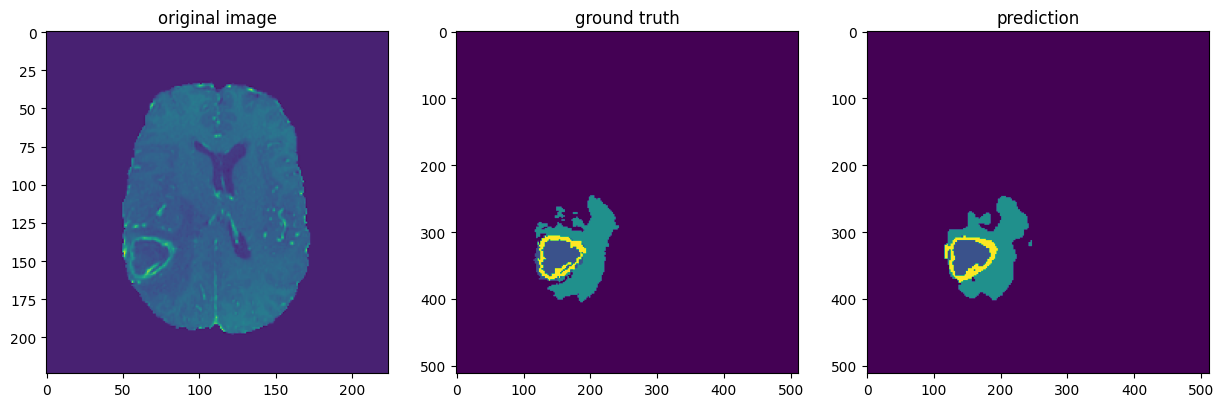

In [25]:
# use sitk to load mri_35131_0A_gt.nii.gz


def draw_figures(file_folder, file_name):
    original_img = sitk.ReadImage(os.path.join(file_folder, f'{file_name}_img.nii.gz')) # this is a 2D image
    original_img_array = sitk.GetArrayFromImage(original_img)
    

    gt_img = sitk.ReadImage(os.path.join(file_folder, f'{file_name}_gt.nii.gz')) # this is a 2D image
    gt_img_array = sitk.GetArrayFromImage(gt_img)
    

    pred_img = sitk.ReadImage(os.path.join(file_folder, f'{file_name}_pred.nii.gz')) # this is a 2D image
    pred_img_array = sitk.GetArrayFromImage(pred_img)

    # draw figures in one row and three columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_img_array)
    axes[0].set_title('original image')
    axes[1].imshow(gt_img_array)
    axes[1].set_title('ground truth')
    axes[2].imshow(pred_img_array)
    axes[2].set_title('prediction')
    plt.show()
    
draw_figures("predictions", "mri_35131_0A")